In [ ]:
!pip install -U imbalanced-learn

In [2]:
# first neural network with keras tutorial
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN

Using TensorFlow backend.


In [3]:
RANDOM_SEED = 314 #used to help randomly select the data points
TEST_PCT = 0.3 # 20% of the data

In [4]:
dataset = pd.read_csv('creditcard2.csv', delimiter=',')
# split into input (X) and output (y) variables

In [5]:
dataset = dataset.drop(['Time','Amount'],axis=1)

In [6]:
from sklearn.model_selection import train_test_split
# 80% for the training set and 20% for the testing set
train, test = train_test_split(dataset, test_size=TEST_PCT,random_state=RANDOM_SEED)

In [7]:
X = train.iloc[:, 0:28]
y = train.iloc[:,28:29]

In [8]:
 from collections import Counter

In [9]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[(0, 199036), (1, 199036)]


In [10]:
X = X_resampled
y = y_resampled
print(sorted(Counter(y).items()))

[(0, 199036), (1, 199036)]


In [ ]:
# define the keras model
model = Sequential()
model.add(Dense(28, input_dim=28, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset

In [ ]:
model.fit(X, y, epochs=200, batch_size=1000)
# evaluate the keras model
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

In [13]:
x_test = test.iloc[:, 0:28]
y_true = test.iloc[:,28:29]

In [14]:
y_pred = model.predict(x_test)

In [15]:
y_pred = (y_pred > 0.5)

In [16]:
import numpy as np

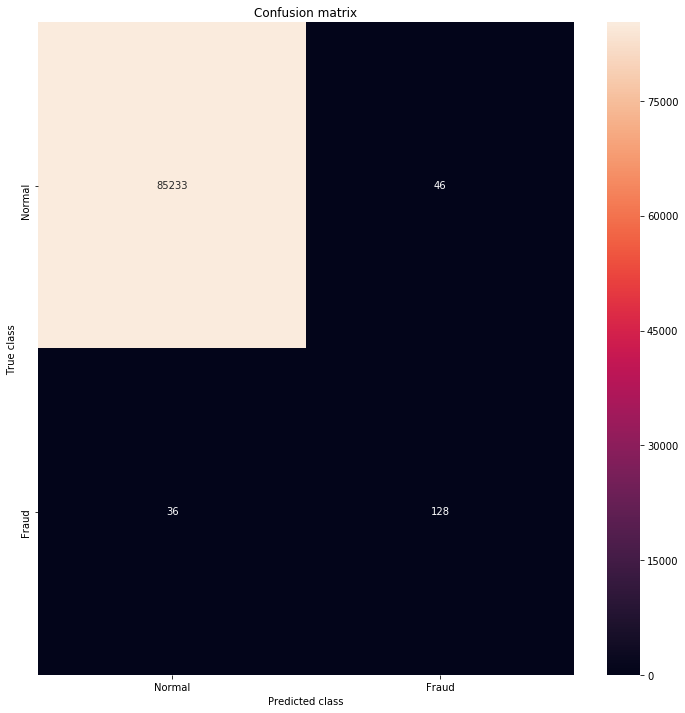

In [23]:
from sklearn.metrics import confusion_matrix, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
LABELS = ["Normal","Fraud"]
conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)
tn, fp, fn, tp = conf_matrix.ravel() 
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show();

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85279
           1       0.74      0.78      0.76       164

    accuracy                           1.00     85443
   macro avg       0.87      0.89      0.88     85443
weighted avg       1.00      1.00      1.00     85443



In [19]:
from sklearn.metrics import classification_report, accuracy_score

In [20]:
print ("Accuracy Score: ", accuracy_score(y_true, y_pred))

Accuracy Score:  0.9990402958697612


In [24]:
from sklearn.metrics import classification_report, precision_score, recall_score

In [22]:
print ("Precision Score: ", precision_score(y_true, y_pred))

Precision Score:  0.735632183908046


In [25]:
print ("Recall Score: ", recall_score(y_true, y_pred))

Recall Score:  0.7804878048780488
